### Draft Code for Transfer Learning

In [1]:
# General Libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Used to silent TF info and warnings when using GPU, error messeges still come up
import numpy as np
from numpy import savetxt
import pandas as pd
from pandas import read_csv
import time
# ML libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, AveragePooling3D, GlobalAveragePooling3D, Dense, Flatten
from tensorflow.keras.layers import Dropout, SpatialDropout3D, Activation, BatchNormalization
from tensorflow.keras.layers import Input, concatenate, add
from tensorflow.python.keras.utils import losses_utils
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from contextlib import redirect_stdout
# Visualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)
###################################################
# Set pwd
os.chdir('/home/elmorsym/transferLearning/')
#
K.set_image_data_format('channels_last') #'channels_first'
print('Keras Image data format: '+K.image_data_format()) #defult "channels_last"
#
####################################################
# Choose GPU to use (8 available) - skip 0 (busy)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[4:8], 'GPU')
print('Number of detected GPUs: '+str(len(gpus)))
###################################################

Keras Image data format: channels_last
Number of detected GPUs: 8


In [2]:
###################################################
# Data management
###################################################
# Load data
def load_data(data_file, rotate=False):
    # Load data
    data = np.load("datasets/"+data_file+".npz", allow_pickle=True)
    print(data.files)
    cols = ['casenames', 'porosity', 'esv', 'rock_type', 'direction', 'k']
    if rotate == True:
        print("Rotating data..")
        ###################################################
        # Load data input and target & rotate, size x3
        x = np.concatenate((data['samples'], np.swapaxes(data['samples'], 2, 3), np.swapaxes(data['samples'], 1, 3)), axis=0)
        y = np.concatenate((data['kx'], data['ky'], data['kz']), axis=0)
        ##################################################
        # Load data info & rotate, size x3
        L = len(data['casenames'])
        info = pd.DataFrame(index=range(L*3),columns=cols)
        #
        info["casenames"] = np.concatenate((data['casenames'], data['casenames'], data['casenames']), axis=0)
        info["porosity"] = np.concatenate((data['porosity'], data['porosity'], data['porosity']), axis=0)
        info["esv"] = np.concatenate((data['esv'], data['esv'], data['esv']), axis=0)
        info["rock_type"] = np.concatenate((data['rock_type'], data['rock_type'], data['rock_type']), axis=0)
        info["direction"] = np.concatenate((np.ones(L)*1, np.ones(L)*2, np.ones(L)*3), axis=0)
        info["k"] = np.concatenate((data['kx'], data['ky'], data['kz']), axis=0)
        print(info.columns)
        print("Rotation complete!")
    else:
        ###################################################
        # Load data input and target
        x = data['samples']
        y = data['k']
        ###################################################
        # Load data info
        info = pd.DataFrame(index=range(len(data['casenames'])),columns=cols)
        #
        info["casenames"] = data['casenames']
        info["porosity"] = data['porosity']
        info["esv"] = data['esv']
        info["rock_type"] = data['rock_type']
        info["direction"] = data['direction']
        info["k"] = data['k']
        ###################################################
    del data

    return x, y, info 

# Get data summary
def data_summary(hat, true, percentile):
    hat = pd.DataFrame(hat)
    true = pd.DataFrame(true)
    # calc error
    RE = (hat-true)/true
    ARE = RE.abs()  
    # Summarze data in one dataframe
    data_summary = pd.DataFrame(columns=['hat', 'true', 'ARE'], index=range(len(true)))
    data_summary['true'] = true.reset_index(drop=True)
    data_summary['hat'] = hat
    data_summary['ARE'] = ARE.reset_index(drop=True)    
    # 95 percintile of Testing data results
    data_summary = data_summary[(data_summary['ARE'] < data_summary['ARE'].quantile(percentile))]
    
    return data_summary

# prinit predictions results    
def print_results(MARE, MedRE):
    print('Testing MARE  [%] = '+str(round(MARE*100, 1)))
    print('Testing MedRE [%] = '+str(round(MedRE*100, 1)))
    return

###################################################
# Visualization
###################################################
def hist(x, bins=30, color='lightgreen', alpha=1, xlabel='xlabel', title='title',
         stat=None, xlim=None, ylim=None, version=''):
    MARE = np.mean(abs(x))
    MedRE = np.median(abs(x))
    plt.hist(x, bins=bins, color=color, alpha=alpha, edgecolor='black', linewidth=0.7)
    
    plt.tick_params(direction="in", pad=5, labelsize=12)
    if ylim != None:
        plt.ylim(ylim[0],ylim[1])
    if xlim != None:
        plt.xlim(xlim[0],xlim[1])
    if stat == False:
        plt.title(title, size=12)
    else:
        MARE = np.mean(abs(x))
        MedRE = np.median(abs(x))
        plt.axvline(MARE, color='r', linestyle='dashed', linewidth=1)
        plt.axvline(MedRE, color='k', linestyle='dashed', linewidth=1)
        plt.legend(['Mean', 'Median'], loc='upper right')
        plt.title(title+'\n MARE= '+str(round(MARE, 2)), size=12)
        # plt.title(title, size=12)
    plt.ylabel('Number of samples [-]', size=12)
    plt.xlabel(xlabel, size=12)
    plt.savefig(color+version+'_hist.png', dpi=300)
    plt.savefig(color+version+'_hist.pdf', dpi=300)
    #plt.savefig('K_hist.eps', format='eps')
    plt.show()
    #plt.clf()
    return

###################################################
# Machine learning
###################################################
# Inception module function
def inception_module(layer_in, f1, f2, strides):
	# 7 x 7 x 7 conv
    conv7 = layer_in
    conv7 = Conv3D(f1, 7, strides=strides, padding='same', use_bias="False")(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv3D(f1, 7, strides=strides, padding='same', use_bias="False")(conv7)
    conv7 = Activation('relu')(conv7)
	# 15 x 15 x 15 conv
    conv15 = layer_in
    conv15 = Conv3D(f2, 15, strides=strides, padding='same', use_bias="False")(conv15)
    conv15 = Activation('relu')(conv15)
    conv15 = Conv3D(f2, 15, strides=strides, padding='same', use_bias="False")(conv15)
    conv15 = Activation('relu')(conv15)
    # Concatenate the two braches
    layer_out = concatenate([conv7, conv15], axis=-1) # without skip connnection
    #
    return layer_out
###################################################
# 3D-CNN model
def init_CNN_model():
    # Define model input
    input_image = Input(shape=(100, 100, 100, 1))
    # Add inception module
    layer = inception_module(input_image, 16, 16, strides=2)
    layer = BatchNormalization()(layer)
    layer = Conv3D(16, 2, strides=2, padding='same', use_bias="False")(layer) #down-scale - Conv-pooling
    # Deep Learning module
    layer = Conv3D(32, 5, strides=1, padding='same', use_bias="False")(layer)
    layer = Activation('relu')(layer)
    layer = Conv3D(32, 5, strides=1, padding='same', use_bias="False")(layer)
    layer = Activation('relu')(layer)
    layer = BatchNormalization()(layer)
    layer = SpatialDropout3D(0.1)(layer)
    layer = Conv3D(32, 2, strides=2, padding='same', use_bias="False")(layer) #down-scale - Conv-pooling
    # FCL module
    layer = Flatten()(layer)
    layer = Dense(128, use_bias="False", activation='relu')(layer)
    layer = Dropout(0.1)(layer)
    layer = Dense(64, use_bias="False", activation='relu')(layer)
    layer = Dense(1)(layer)
    # Create the model
    model = keras.Model(inputs=input_image, outputs=layer)
    #
    # print the network
    # print(model.summary())
    #
    return model
###################################################
# 3D-CNNtL model
def init_3D_CNNtL_model(weights, top_trainable):
    #
    if weights == None:
        model = init_CNN_model()
    else:
        cnn_model = init_CNN_model()
        # Load the best pre-trained weights from the desk
        folder_name = './networks/0 - COM_65248_0.2_adam_MAPE_100_3dir_relu_InsNet_nobias_2B_BSS_KLS_BrSS_ELS_C1_C2_65K_1_USE_BEST'
        checkpoint_filepath = folder_name+'/checkpoint'
        # Load the model from disk later using:
        cnn_model.load_weights(checkpoint_filepath)
        cnn_model._name = "3D-CNN"
        # cnn_model = tf.keras.models.load_model(folder_name+'/saved_model.pb', compile=False)
        #
        # Get the dictionary of config for 3d-cnn
        cnn_config = cnn_model.get_config()
        # Change the defult input shape to a new input shape
        cnn_config["layers"][0]["config"]["batch_input_shape"] = (None, 100, 100, 100, 1)
        # Create new model with the updated configuration
        cnn_updated = Model.from_config(cnn_config)
        # 
        cnn_updated_config = cnn_updated.get_config()
        cnn_updated_layer_names = [cnn_updated_config['layers'][x]['name'] for x in range(len(cnn_updated_config['layers']))]
        #
        # Update weights for all layers. And for the first conv layer, copy the first
        # three layer weights and fill others with the average of all three. 
        for layer in cnn_model.layers:
            if layer.name in cnn_updated_layer_names:
                if layer.get_weights() != []:  # All convolutional layers and layers with weights (no input layer or any pool layers)
                    target_layer = cnn_updated.get_layer(layer.name)
                    target_layer.set_weights(layer.get_weights())   # Set weights to all other layers. 
                    target_layer.trainable = top_trainable  # ou can make this trainable if you want.
        #
        cnn_updated_top = keras.Model(inputs=cnn_updated.inputs, outputs=cnn_updated.layers[-6].output)
        #
        # Add the regression module
        layer = Flatten()(cnn_updated_top.layers[-1].output)
        layer = Dense(128, use_bias="True", activation='relu')(layer)
        layer = Dropout(0.1)(layer)
        layer = Dense(64, use_bias="True", activation='relu')(layer)
        output = Dense(1)(layer)
        # Create the new model
        model = keras.Model(inputs=cnn_updated_top.inputs, outputs=output)
        #
        # print the network
        print(cnn_updated.summary())
    print(model.summary())
    #
    return model 
###################################################
# VGG Model (Random Weights)
def init_VGG16_model():
    # Load VGG16 model
    from tensorflow.keras.applications.vgg16 import VGG16
    # Define model input
    h, w, c = 224, 224, 3
    input_shape = (h, w, c)
    vgg_model = VGG16(include_top=False, weights= None, input_shape=input_shape)
    #
    # Add the regression module
    layer = Flatten()(vgg_model.layers[-1].output)
    layer = Dense(128, use_bias="True", activation='relu')(layer)
    layer = Dropout(0.1)(layer)
    layer = Dense(64, use_bias="True", activation='relu')(layer)
    output = Dense(1)(layer)
    # Create the new model
    model = keras.Model(inputs=vgg_model.inputs, outputs=output)
    # print the network
    print(vgg_model.summary())
    #
    return vgg_model
###################################################
# VGG Model (Exclude Top Model)
def init_VGG16_NoTop_model():
    # Load VGG16 model
    from tensorflow.keras.applications.vgg16 import VGG16
    # Define model input
    h, w, c = 224, 224, 3
    input_shape = (h, w, c)
    vgg_model = VGG16(include_top=False, weights= 'imagenet', input_shape=input_shape)
    # Set layers trainable to False
    for layer in vgg_model.layers:
        layer.trainable = False
    #
    # print the network
    print(vgg_model.summary())
    #
    return vgg_model
###################################################
# VGGtL Model
def init_VGG16tL_model(input_size, weights, top_trainable):
    # Load VGG16 model
    from tensorflow.keras.applications.vgg16 import VGG16
    # Define model input
    h, w, c = input_size, input_size, input_size
    input_shape = (h, w, c)
    input_image = Input(shape=input_shape)
    #
    # Import vgg model by not defining an input shape. 
    vgg_model = VGG16(include_top=False, weights=weights)
    # Get the dictionary of config for vgg16
    vgg_config = vgg_model.get_config()
    # Change the defult input shape to a new input shape
    vgg_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)
    # Create new model with the updated configuration
    vgg_updated = Model.from_config(vgg_config)
    
    # Function to get average weights for the first ooriginal 3 channels and copy them to the new 100 channels
    def avg_and_copy_wts(weights, num_channels_to_fill):  # num_channels_to_fill are the extra channels for which we need to fill weights
        average_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)  # Find mean along the channel axis (second to last axis)
        wts_copied_to_mult_channels = np.tile(average_weights, (num_channels_to_fill, 1)) # Repeat (copy) the array multiple times
    
        return(wts_copied_to_mult_channels)
    #
    # 
    vgg_updated_config = vgg_updated.get_config()
    vgg_updated_layer_names = [vgg_updated_config['layers'][x]['name'] for x in range(len(vgg_updated_config['layers']))]
    first_conv_name = vgg_updated_layer_names[1]
    #
    # Update weights for all layers. And for the first conv layer, copy the first
    # three layer weights and fill others with the average of all three. 
    for layer in vgg_model.layers:
        if layer.name in vgg_updated_layer_names:

            if layer.get_weights() != []:  # All convolutional layers and layers with weights (no input layer or any pool layers)
                target_layer = vgg_updated.get_layer(layer.name)
            
                if layer.name in first_conv_name:    # For the first convolutionl layer
                    weights = layer.get_weights()[0]
                    biases  = layer.get_weights()[1]
                
                    weights_all_channels = avg_and_copy_wts(weights, c)
                                                            
                    target_layer.set_weights([weights_all_channels, biases])  # Now set weights for the first conv. layer
                    target_layer.trainable = top_trainable   # You can make this trainable if you want. 
            
                else:
                    target_layer.set_weights(layer.get_weights())   # Set weights to all other layers. 
                    target_layer.trainable = top_trainable  # ou can make this trainable if you want.
    #
    # Add the regression module
    layer = Flatten()(vgg_updated.layers[-1].output)
    layer = Dense(128, use_bias="True", activation='relu')(layer)
    layer = Dropout(0.1)(layer)
    layer = Dense(64, use_bias="True", activation='relu')(layer)
    output = Dense(1)(layer)
    # Create the new model
    model = keras.Model(inputs=vgg_updated.inputs, outputs=output)
    #
    # print the network
    print(vgg_updated.summary())
    print(model.summary())
    #
    return model
###################################################
# ResNet50 Model (Exclude Top Model)
def init_ResNet50_NoTop_model():
    # Load InceptionV3 model
    from tensorflow.keras.applications.resnet50 import ResNet50
    # Define model input
    h, w, c = 224, 224, 3
    input_shape = (h, w, c)
    input_image = Input(shape=input_shape)
    resnet_model = ResNet50(include_top=False, weights= 'imagenet', input_shape=input_shape)
    # Set layers trainable to False
    for layer in resnet_model.layers:
        layer.trainable = False
    #
    # print the network
    print(resnet_model.summary())
    #
    return resnet_model
###################################################
# ResNet50tL Model
def init_ResNet50tL_model(input_size, weights, top_trainable):
    # Load ResNet50 model
    from tensorflow.keras.applications.resnet50 import ResNet50
    # Define model input
    h, w, c = input_size, input_size, input_size
    input_shape = (h, w, c)
    input_image = Input(shape=input_shape)
    #
    # Import ResNet50 model without defining an input shape. 
    resnet_model = ResNet50(include_top=False, weights=weights)
    # Get the dictionary of config for vgg16
    resnet_config = resnet_model.get_config()
    # Change the defult input shape to a new input shape
    resnet_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)
    # Create new model with the updated configuration
    resnet_updated = Model.from_config(resnet_config)
    
    
    def avg_and_copy_wts(weights, num_channels_to_fill):
        average_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)
        wts_copied_to_mult_channels = np.tile(average_weights, (num_channels_to_fill, 1))
    
        return(wts_copied_to_mult_channels)
    #
    # 
    resnet_updated_config = resnet_updated.get_config()
    resnet_updated_layer_names = [resnet_updated_config['layers'][x]['name'] for x in range(len(resnet_updated_config['layers']))]
    first_conv_name = resnet_updated_layer_names[2]
    # 
    for layer in resnet_model.layers:
        if layer.name in resnet_updated_layer_names:
            #print(layer.name)

            if layer.get_weights() != []:  
                target_layer = resnet_updated.get_layer(layer.name)
                
                if layer.name in first_conv_name:
                    weights = layer.get_weights()[0]
                    biases  = layer.get_weights()[1]
                
                    weights_all_channels = avg_and_copy_wts(weights, c)
                                                            
                    target_layer.set_weights([weights_all_channels, biases])
                    target_layer.trainable = top_trainable

                else:
                    target_layer.set_weights(layer.get_weights())
                    target_layer.trainable = top_trainable
    #
    # Add the regression module
    layer = Flatten()(resnet_updated.layers[-1].output)
    layer = Dense(128, use_bias="True", activation='relu')(layer)
    layer = Dropout(0.1)(layer)
    layer = Dense(64, use_bias="True", activation='relu')(layer)
    output = Dense(1)(layer)
    # Create the new model
    model = keras.Model(inputs=resnet_updated.inputs, outputs=output)
    #
    # print the network
    print(resnet_updated.summary())
    print(model.summary())
    #
    return model
###################################################
# InceptionV3 Model
def init_InceptionV3_model():
    # Load InceptionV3 model
    from tensorflow.keras.applications.inception_v3 import InceptionV3
    # Define model input
    h, w, c = 224, 224, 3 #299, 299
    input_shape = (h, w, c)
    input_image = Input(shape=input_shape)
    inception_model = InceptionV3(include_top=False, weights= 'imagenet', input_shape=input_shape)
    # Set layers trainable to False
    for layer in inception_model.layers:
        layer.trainable = False
    #
    # print the network
    print(inception_model.summary())
    #
    return inception_model
###################################################
# InceptionV3tL Model
def init_InceptionV3tL_model(input_size, weights, top_trainable):
    # Load ResNet50 model
    from tensorflow.keras.applications.inception_v3 import InceptionV3
    # Define model input
    h, w, c = input_size, input_size, input_size
    input_shape = (h, w, c)
    input_image = Input(shape=input_shape)
    #
    # Import ResNet50 model without defining an input shape. 
    resnet_model = InceptionV3(include_top=False, weights=weights)
    # Get the dictionary of config for vgg16
    resnet_config = resnet_model.get_config()
    # Change the defult input shape to a new input shape
    resnet_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)
    # Create new model with the updated configuration
    resnet_updated = Model.from_config(resnet_config)
    
    
    def avg_and_copy_wts(weights, num_channels_to_fill):
        average_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)
        wts_copied_to_mult_channels = np.tile(average_weights, (num_channels_to_fill, 1))
    
        return(wts_copied_to_mult_channels)
    #
    # 
    resnet_updated_config = resnet_updated.get_config()
    resnet_updated_layer_names = [resnet_updated_config['layers'][x]['name'] for x in range(len(resnet_updated_config['layers']))]
    first_conv_name = resnet_updated_layer_names[1]
    # 
    for layer in resnet_model.layers:
        if layer.name in resnet_updated_layer_names:
            #print(layer.name)

            if layer.get_weights() != []:  
                target_layer = resnet_updated.get_layer(layer.name)
                
                if layer.name in first_conv_name:
                    weights = layer.get_weights()[0]
                
                    weights_all_channels = avg_and_copy_wts(weights, c)
                                                            
                    target_layer.set_weights([weights_all_channels])
                    target_layer.trainable = top_trainable

                else:
                    target_layer.set_weights(layer.get_weights())
                    target_layer.trainable = top_trainable
    #
    # Add the regression module
    layer = Flatten()(resnet_updated.layers[-1].output)
    layer = Dense(128, use_bias="True", activation='relu')(layer)
    layer = Dropout(0.1)(layer)
    layer = Dense(64, use_bias="True", activation='relu')(layer)
    output = Dense(1)(layer)
    # Create the new model
    model = keras.Model(inputs=resnet_updated.inputs, outputs=output)
    #
    # print the network
    print(resnet_updated.summary())
    print(model.summary())

    return model
    #



###################################################
## TEST
###################################################
# InceptionV3tL Model
def init_InceptionV3tL_SC_model(input_size):
    # Load ResNet50 model
    from tensorflow.keras.applications.inception_v3 import InceptionV3
    # Define model input
    h, w, c = input_size, input_size, input_size
    #
    # Import ResNet50 model without defining an input shape. 
    resnet_model = InceptionV3(include_top=False, weights=None)
    # Get the dictionary of config for vgg16
    resnet_config = resnet_model.get_config()
    # Change the defult input shape to a new input shape
    resnet_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)
    # Create new model with the updated configuration
    resnet_updated = Model.from_config(resnet_config)
    
    
    def avg_and_copy_wts(weights, num_channels_to_fill):
        average_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)
        wts_copied_to_mult_channels = np.tile(average_weights, (num_channels_to_fill, 1))
    
        return(wts_copied_to_mult_channels)
    #
    # 
    resnet_updated_config = resnet_updated.get_config()
    resnet_updated_layer_names = [resnet_updated_config['layers'][x]['name'] for x in range(len(resnet_updated_config['layers']))]
    first_conv_name = resnet_updated_layer_names[1]
    # 
    for layer in resnet_model.layers:
        if layer.name in resnet_updated_layer_names:
            #print(layer.name)

            if layer.get_weights() != []:  
                target_layer = resnet_updated.get_layer(layer.name)
                
                if layer.name in first_conv_name:
                    weights = layer.get_weights()[0]
                
                    weights_all_channels = avg_and_copy_wts(weights, c)
                                                            
                    target_layer.set_weights([weights_all_channels])
                    target_layer.trainable = True

                else:
                    target_layer.set_weights(layer.get_weights())
                    target_layer.trainable = True
    #
    # Add the regression module
    layer = Flatten()(resnet_updated.layers[-1].output)
    layer = Dense(128, use_bias="True", activation='relu')(layer)
    layer = Dropout(0.1)(layer)
    layer = Dense(64, use_bias="True", activation='relu')(layer)
    output = Dense(1)(layer)
    # Create the new model
    model = keras.Model(inputs=resnet_updated.inputs, outputs=output)
    #
    # print the network
    print(resnet_updated.summary())
    print(model.summary())

    return model
    #

In [3]:
# For testing
# model = init_CNN_model()
# model = init_VGG16_model()
# model = init_InceptionV3_model()
# model = init_ResNet50_model()
# tL Models
# model = init_3D_CNNtL_model()
# model = init_VGG16tL_model(input_size=100)
# model = init_ResNet50tL_model(input_size=100)
# model = init_InceptionV3tL_model(input_size=100)

# from tensorflow.keras.applications.resnet50 import ResNet50
# model = ResNet50(include_top=True, weights=None)
# print(model.summary())

''''
# Save model summary to a text file
with open('./model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()
'''

"'\n# Save model summary to a text file\nwith open('./model_summary.txt', 'w') as f:\n    with redirect_stdout(f):\n        model.summary()\n"

In [4]:
# Input data
input_size = 100
if input_size == 150:
    data_file_train = "dataset_BrSS_BSS_KLS_len_13347_size_150_sp_10_len_12013_bal_16438_train" # update
    data_file_test = "dataset_BrSS_BSS_KLS_len_13347_size_150_sp_10_len_1334_3dir_4002_test"    # update
if input_size == 100:
    data_file_train = "dataset_BrSS_BSS_KLS_len_13347_size_100_sp_10_len_12013_bal_16438_train" # update
    data_file_test = "dataset_BrSS_BSS_KLS_len_13347_size_100_sp_10_len_1334_3dir_4002_test"    # update

# Load data
x_train, y_train, info_train = load_data(data_file_train, rotate=False)
x_test, y_test, info_test = load_data(data_file_test, rotate=False)

['samples', 'casenames', 'porosity', 'esv', 'rock_type', 'direction', 'k']
['samples', 'casenames', 'porosity', 'esv', 'rock_type', 'direction', 'k']


In [5]:
# Training parameters
trail = '_-1_FCL_128-64_mse_bias_SC_new_1'
network = 'ResNet' #'3D-CNN', 'VGG', 'ResNet', 'Inception'
weights = None #None #'imagenet'
top_trainable = True #False, True
epochs = 10
batch_size = 32
loss = tf.keras.losses.MeanSquaredError() # 'mean_absolute_percentage_error'
optmizer = 'adam' #'sgd' #, 'adam'
####################################################
# Factor results
factor = 10000
y_train = y_train*factor
y_test = y_test*factor
####################################################
data_len = len(y_train)
save_name = 'networks/TL_'+network+'_len_'+str(data_len)+'_inp_'+str(input_size)+'_epochs_'+str(epochs)+'_BS_'+str(batch_size)+trail
# Create Diectory
isExist = os.path.exists(save_name)
if not isExist:
     os.mkdir(save_name)
#
# callbacks
csv_logger = CSVLogger(save_name+'/training.log')
#
checkpoint_filepath = save_name+'/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
                            filepath=checkpoint_filepath,
                            save_weights_only=True,
                            monitor='val_loss',
                            mode='min',
                            save_best_only=False)
#
callbacks = [csv_logger, model_checkpoint_callback]
#

#### Training the model

In [6]:
# Reshape the images from (100, 100, 100) to (100, 100, 100, 1) # Only in case of 3D CNN
if network == '3D-CNN' and x_train.ndim <= 4:
     x_train = np.expand_dims(x_train, axis=4)
     x_test = np.expand_dims(x_test, axis=4)
####################################################
# Use strategy for Multiple GPUs
tf.debugging.set_log_device_placement(True)
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # Create the model
    #
    # model = init_CNN_model()
    if network == 'VGG':
        model = init_VGG16tL_model(input_size, weights, top_trainable)
    if network == 'ResNet':
        model = init_ResNet50tL_model(input_size, weights, top_trainable)
    if network == 'Inception':
        # model = init_InceptionV3tL_SC_model(input_size)
        model = init_InceptionV3tL_model(input_size, weights, top_trainable)
    if network == '3D-CNN':
        model = init_3D_CNNtL_model(weights, top_trainable)
    #
#
model.compile(optimizer=optmizer, 
              loss=loss, 
              metrics=['mean_absolute_percentage_error'])
###################################################
# Print model summary
print(model.summary())
# Save model summary to a text file
with open(save_name+'/model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhos

### Fit the model

In [7]:
# Fit the model
start_time = time.time() 
history = model.fit(
          x_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split = 0.1,
          shuffle=True,
          callbacks=[callbacks])
end_time = time.time()
training_time = end_time - start_time
####################################################
# Save the model to disk.
tf.saved_model.save(model, save_name)
np.save(save_name+'/history.npy', history.history)
# The model weights (that are considered the best) are loaded into the model.
# model.load_weights(checkpoint_filepath)
####################################################
with open(save_name+'/model_summary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDatase

#### Testing the model

In [8]:
# Predictions
predict_train = model.predict(x_train)
#
start_time = time.time() 
#
predict_test = model.predict(x_test)
#
end_time = time.time()
inference_time = (end_time - start_time)/len(predict_test)
####################################################
# de-Factor results
if factor != 1:
    predict_train = predict_train/factor
    predict_test = predict_test/factor
    y_train = y_train/factor
    y_test = y_test/factor
    factor = 1
####################################################
# Store summary
data_summary_train = data_summary(hat=predict_train, true=y_train, percentile=0.90)
data_summary_test = data_summary(hat=predict_test, true=y_test, percentile=0.95)
# Save results
data_summary_train.to_csv(save_name+'/data_summary_train.csv', index=False)
data_summary_test.to_csv(save_name+'/data_summary_test.csv', index=False)
# Stat
print(f"Training Time: {(training_time)/60:.2f} mins")
print(f"Inference Time: {inference_time*1000:.2f} ms")
MARE = np.mean(data_summary_test["ARE"])
MedRE = np.median(abs(data_summary_test["ARE"]))
# Print stat
print_results(MARE, MedRE)

with open(save_name+'/results_summary.txt', 'w') as f:
    with redirect_stdout(f):
        print(f"Training Time: {(training_time)/60:.2f} mins")
        print(f"Inference Time: {(inference_time)*1000:.2f} ms")
        print_results(MARE, MedRE)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDatase

#### Plot Prediction Results

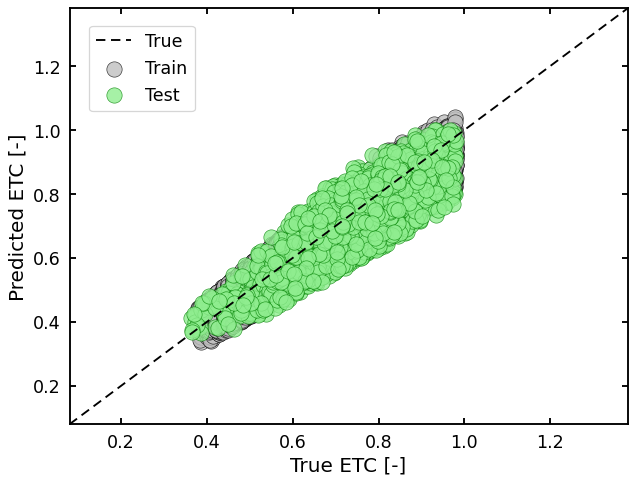

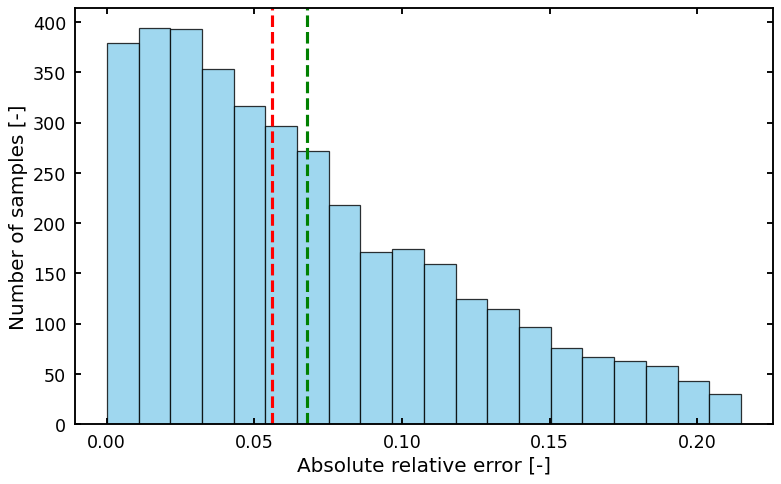

In [9]:
# LateX format for plots
# mpl.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})
mpl.rcParams.update(mpl.rcParamsDefault)

# set plot resoluton
plt.rcParams["figure.dpi"] = 120
plt.rcParams['axes.linewidth'] = 1.5
#
# Scatter plot Log scale Train and Test sets
#
font_size = 16
max = 1.38
min = 0.08
y1 = data_summary_train["hat"]
x1 = data_summary_train["true"] 
y2 = data_summary_test["hat"]
x2 = data_summary_test["true"]
#
plt.figure(figsize=(8, 6), dpi=90)
plt.plot([min, max], [min, max], color='k', linestyle='--', dashes=(5, 3), linewidth=1.5, alpha=1)
#
plt.scatter(x1, y1, c='silver', s=150, alpha=0.8, edgecolors='k', linewidth=0.5)
plt.scatter(x2, y2, c='lightgreen', s=150, alpha=0.8, edgecolors='g', linewidth=0.5)
#
plt.ylim([min, max])
plt.xlim([min, max])
#
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in", pad=7, length=5, width=1.5, labelsize=font_size-2, axis='both', which='both')
plt.legend(['True', 'Train', 'Test'], loc='upper left',fontsize=font_size-2, bbox_to_anchor=(0.02, 0.98))
plt.ylabel('Predicted ETC [-]', size=font_size)
plt.xlabel('True ETC [-]', size=font_size)
plt.title("", size=font_size)
plt.savefig(save_name+'/predictions_scatter.png', bbox_inches='tight', dpi=400)
plt.savefig(save_name+'/predictions_scatter.pdf', bbox_inches='tight', dpi=400)
plt.show()
# plt.clf()
## Plot histograms
x = data_summary_test['ARE']
color = 'skyblue'
bins = 20
plt.figure(figsize=(10, 6), dpi=90)
plt.hist(x, bins=bins, color=color, alpha= 0.8, edgecolor='black', linewidth=1)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in", pad=7, length=5, width=1.5, labelsize=font_size-2)
#plt.ylim(-0.01, 500)
#plt.xlim(-0.01, 0.4)
MARE = np.mean(abs(x))
MedRE = np.median(abs(x))
plt.axvline(MARE, color='g', linestyle='dashed', linewidth=2.5)
plt.axvline(MedRE, color='r', linestyle='dashed', linewidth=2.5)
plt.ylabel('Number of samples [-]', size=font_size)
plt.xlabel('Absolute relative error [-]', size=font_size)
plt.savefig(save_name+'/ARE_hist.png', bbox_inches='tight', dpi=400)
plt.savefig(save_name+'/ARE_hist.pdf', bbox_inches='tight', dpi=400)
#plt.savefig('K_hist.eps', format='eps')
plt.show()
#plt.clf()